In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LSTM
from tensorflow.keras.layers import TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from focal_loss import SparseCategoricalFocalLoss

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy

In [3]:
data = pd.read_csv('train.csv', header=None)

X = all columns except column 0 (id) and 961 (labels) <br />
y = column 961 (labels) 

In [ ]:
X = data.drop(columns=[0, 961])
y = data[961]

Encode labels from range 1-49 to range 0-48

In [5]:
label = LabelEncoder()
y = label.fit_transform(y)

Transform values to same range for improving training convergence speed

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

Reshape 960 features into 16 x 60 x 1 since Conv2D() expects a three dimensional input. <br />
The first dimension is 16 because there are 16 frames and the second dimension is 60 because each frame has 60 features (x, y, z, coordinates for 20 skeleton joints).

In [7]:
X = np.array(X).reshape(-1, 16, 60, 1)

StratifiedKFold() splits the training data into K folds keepinng the class proportions same. This is important in case of class imabalanced data. 'shuffle' parameter is set True because the training data is contiguous is class and we want each fold to be representative of the entire training data. <br />

In [9]:
folds = list(StratifiedKFold(n_splits=9, shuffle=True, random_state=1).split(X, y))

ReduceLROnPlateau() callback reduces the learning rate by a factor of 0.1 after 5 epochs of non-improving validation loss. Reducing the learning rate in the later epochs helps improve the accuracy.

In [10]:
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    return [reduce_lr_loss]

CNN model with 3 convolution layers and 2 dense layers

In [11]:
def get_model():
    
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', padding='same', kernel_initializer='he_uniform', input_shape = X[0].shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation = 'relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), activation = 'relu', padding='same', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2, 2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(49, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

Build K models using K-1 folds as training set and 1 fold as validation set and store them in a list. We use this list of models for majority voting for prediction.

For each fold, we define class weights as : <br /><br /><center><b>class weight of class i = (1 / no. of samples of class i in the current fold) * (total samples in the current fold / 2)</b></center><br />

The above formula assigns higher class weight to minority class and lower class weight to majority class. Thus misclassification of a minority class sample leads to a higher penalty (loss) during training.

In [12]:
history = []
models = []

for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    class_weights = {}
    y_train_cv_copy = np.array(y_train_cv)

    for class_label in range(49):
        label_count = np.sum(y_train_cv_copy==class_label)
        class_weights[class_label] = (1/label_count)*(X_train_cv.shape[0]/2)
    
    callbacks = get_callbacks()
    model = get_model()
    fold_history = model.fit(X_train_cv, y_train_cv, batch_size=128, epochs=77, verbose=1, validation_data=(X_valid_cv, y_valid_cv), callbacks = callbacks, class_weight=class_weights)
    models.append(model)
    history.append(fold_history)
    print(model.evaluate(X_valid_cv, y_valid_cv))


Fold  0
Epoch 1/77
66/66 [==============================] - 38s 544ms/step - loss: 101.1731 - accuracy: 0.0621 - val_loss: 3.7434 - val_accuracy: 0.0833
Epoch 2/77
66/66 [==============================] - 36s 539ms/step - loss: 90.0561 - accuracy: 0.0856 - val_loss: 3.3394 - val_accuracy: 0.1494
Epoch 3/77
66/66 [==============================] - 35s 535ms/step - loss: 86.0727 - accuracy: 0.1017 - val_loss: 3.1671 - val_accuracy: 0.1762
Epoch 4/77
66/66 [==============================] - 35s 532ms/step - loss: 80.9274 - accuracy: 0.1238 - val_loss: 3.1044 - val_accuracy: 0.2261
Epoch 5/77
66/66 [==============================] - 35s 536ms/step - loss: 78.9633 - accuracy: 0.1377 - val_loss: 3.0077 - val_accuracy: 0.2337
Epoch 6/77
66/66 [==============================] - 35s 535ms/step - loss: 75.1177 - accuracy: 0.1538 - val_loss: 3.0328 - val_accuracy: 0.2165
Epoch 7/77
66/66 [==============================] - 35s 535ms/step - loss: 72.1688 - accuracy: 0.1649 - val_loss: 2.9336 - val

Epoch 35/77
66/66 [==============================] - 35s 537ms/step - loss: 38.8993 - accuracy: 0.3930 - val_loss: 2.0283 - val_accuracy: 0.4276
Epoch 36/77
66/66 [==============================] - 35s 536ms/step - loss: 37.2384 - accuracy: 0.4055 - val_loss: 2.0323 - val_accuracy: 0.4449
Epoch 37/77
66/66 [==============================] - 35s 528ms/step - loss: 37.0180 - accuracy: 0.4032 - val_loss: 2.0599 - val_accuracy: 0.4219
Epoch 38/77
66/66 [==============================] - 34s 519ms/step - loss: 35.9880 - accuracy: 0.4089 - val_loss: 2.0442 - val_accuracy: 0.4401
Epoch 39/77
66/66 [==============================] - 35s 533ms/step - loss: 35.1142 - accuracy: 0.4089 - val_loss: 2.0423 - val_accuracy: 0.4401
Epoch 40/77
66/66 [==============================] - 36s 539ms/step - loss: 35.4329 - accuracy: 0.4182 - val_loss: 2.0345 - val_accuracy: 0.4362

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 41/77
66/66 [=============================

66/66 [==============================] - 34s 520ms/step - loss: 61.7779 - accuracy: 0.2393 - val_loss: 2.5760 - val_accuracy: 0.3001
Epoch 14/77
66/66 [==============================] - 34s 520ms/step - loss: 60.0034 - accuracy: 0.2458 - val_loss: 2.5631 - val_accuracy: 0.3126
Epoch 15/77
66/66 [==============================] - 34s 514ms/step - loss: 59.5805 - accuracy: 0.2586 - val_loss: 2.5213 - val_accuracy: 0.3241
Epoch 16/77
66/66 [==============================] - 34s 517ms/step - loss: 58.2243 - accuracy: 0.2678 - val_loss: 2.4688 - val_accuracy: 0.3384
Epoch 17/77
66/66 [==============================] - 34s 519ms/step - loss: 56.1013 - accuracy: 0.2757 - val_loss: 2.4534 - val_accuracy: 0.3298
Epoch 18/77
66/66 [==============================] - 35s 524ms/step - loss: 54.9541 - accuracy: 0.2816 - val_loss: 2.4127 - val_accuracy: 0.3461
Epoch 19/77
66/66 [==============================] - 34s 514ms/step - loss: 53.3924 - accuracy: 0.3009 - val_loss: 2.3872 - val_accuracy: 0.34

66/66 [==============================] - 27s 411ms/step - loss: 32.0068 - accuracy: 0.4419 - val_loss: 1.9610 - val_accuracy: 0.4736
Epoch 48/77
66/66 [==============================] - 30s 453ms/step - loss: 31.6899 - accuracy: 0.4495 - val_loss: 1.9435 - val_accuracy: 0.4717
Epoch 49/77
66/66 [==============================] - 27s 412ms/step - loss: 30.6609 - accuracy: 0.4561 - val_loss: 1.9558 - val_accuracy: 0.4746
Epoch 50/77
66/66 [==============================] - 29s 434ms/step - loss: 30.5739 - accuracy: 0.4612 - val_loss: 1.9368 - val_accuracy: 0.4871
Epoch 51/77
66/66 [==============================] - 28s 420ms/step - loss: 29.9610 - accuracy: 0.4594 - val_loss: 1.8933 - val_accuracy: 0.4803
Epoch 52/77
66/66 [==============================] - 30s 460ms/step - loss: 30.0438 - accuracy: 0.4699 - val_loss: 1.9214 - val_accuracy: 0.4736
Epoch 53/77
66/66 [==============================] - 27s 410ms/step - loss: 30.1531 - accuracy: 0.4693 - val_loss: 1.9159 - val_accuracy: 0.48

Epoch 26/77
66/66 [==============================] - 28s 423ms/step - loss: 46.7906 - accuracy: 0.3318 - val_loss: 2.1874 - val_accuracy: 0.3941
Epoch 27/77
66/66 [==============================] - 28s 431ms/step - loss: 45.3456 - accuracy: 0.3379 - val_loss: 2.1546 - val_accuracy: 0.4027
Epoch 28/77
66/66 [==============================] - 28s 426ms/step - loss: 44.1658 - accuracy: 0.3481 - val_loss: 2.1802 - val_accuracy: 0.3883
Epoch 29/77
66/66 [==============================] - 30s 449ms/step - loss: 43.4497 - accuracy: 0.3548 - val_loss: 2.1189 - val_accuracy: 0.4267
Epoch 30/77
66/66 [==============================] - 27s 412ms/step - loss: 42.3938 - accuracy: 0.3603 - val_loss: 2.1069 - val_accuracy: 0.4142
Epoch 31/77
66/66 [==============================] - 26s 392ms/step - loss: 41.0674 - accuracy: 0.3721 - val_loss: 2.1175 - val_accuracy: 0.4161
Epoch 32/77
66/66 [==============================] - 26s 392ms/step - loss: 41.8577 - accuracy: 0.3660 - val_loss: 2.1236 - val_ac

66/66 [==============================] - 34s 517ms/step - loss: 27.5485 - accuracy: 0.4974 - val_loss: 1.9114 - val_accuracy: 0.4650
Epoch 61/77
66/66 [==============================] - 34s 521ms/step - loss: 27.6262 - accuracy: 0.5015 - val_loss: 1.9186 - val_accuracy: 0.4545
Epoch 62/77
66/66 [==============================] - 34s 520ms/step - loss: 27.4701 - accuracy: 0.4966 - val_loss: 1.9145 - val_accuracy: 0.4669
Epoch 63/77
66/66 [==============================] - 33s 503ms/step - loss: 26.5644 - accuracy: 0.4951 - val_loss: 1.9155 - val_accuracy: 0.4631
Epoch 64/77
66/66 [==============================] - 34s 509ms/step - loss: 26.0108 - accuracy: 0.5075 - val_loss: 1.9097 - val_accuracy: 0.4573
Epoch 65/77
66/66 [==============================] - 33s 503ms/step - loss: 25.8558 - accuracy: 0.5117 - val_loss: 1.9659 - val_accuracy: 0.4439
Epoch 66/77
66/66 [==============================] - 33s 500ms/step - loss: 25.3525 - accuracy: 0.5167 - val_loss: 1.9197 - val_accuracy: 0.46

66/66 [==============================] - 30s 459ms/step - loss: 56.7666 - accuracy: 0.2693 - val_loss: 2.4836 - val_accuracy: 0.3404
Epoch 17/77
66/66 [==============================] - 31s 476ms/step - loss: 55.7004 - accuracy: 0.2737 - val_loss: 2.4886 - val_accuracy: 0.3135
Epoch 18/77
66/66 [==============================] - 32s 484ms/step - loss: 54.7704 - accuracy: 0.2761 - val_loss: 2.3962 - val_accuracy: 0.3317
Epoch 19/77
66/66 [==============================] - 31s 463ms/step - loss: 53.1299 - accuracy: 0.2793 - val_loss: 2.3655 - val_accuracy: 0.3384
Epoch 20/77
66/66 [==============================] - 31s 470ms/step - loss: 52.3588 - accuracy: 0.2950 - val_loss: 2.3633 - val_accuracy: 0.3509
Epoch 21/77
66/66 [==============================] - 33s 498ms/step - loss: 50.7365 - accuracy: 0.3051 - val_loss: 2.3174 - val_accuracy: 0.3567
Epoch 22/77
66/66 [==============================] - 28s 425ms/step - loss: 50.7526 - accuracy: 0.3001 - val_loss: 2.3281 - val_accuracy: 0.35

66/66 [==============================] - 26s 388ms/step - loss: 28.6291 - accuracy: 0.4787 - val_loss: 1.9274 - val_accuracy: 0.4660
Epoch 73/77
66/66 [==============================] - 26s 396ms/step - loss: 27.8615 - accuracy: 0.4775 - val_loss: 1.9248 - val_accuracy: 0.4679
Epoch 74/77
66/66 [==============================] - 26s 394ms/step - loss: 28.0272 - accuracy: 0.4846 - val_loss: 1.9267 - val_accuracy: 0.4660
Epoch 75/77
66/66 [==============================] - 26s 391ms/step - loss: 28.1238 - accuracy: 0.4781 - val_loss: 1.9241 - val_accuracy: 0.4631
Epoch 76/77
66/66 [==============================] - 25s 381ms/step - loss: 27.9369 - accuracy: 0.4899 - val_loss: 1.9177 - val_accuracy: 0.4775
Epoch 77/77
33/33 [==============================] - 1s 25ms/step - loss: 1.9175 - accuracy: 0.4775
[1.9174778461456299, 0.4774688482284546]

Fold  8
Epoch 1/77
66/66 [==============================] - 26s 389ms/step - loss: 105.1428 - accuracy: 0.0532 - val_loss: 3.8636 - val_accuracy:

Epoch 51/77
66/66 [==============================] - 27s 406ms/step - loss: 31.4789 - accuracy: 0.4509 - val_loss: 1.9418 - val_accuracy: 0.4497
Epoch 52/77
66/66 [==============================] - 27s 403ms/step - loss: 30.2787 - accuracy: 0.4620 - val_loss: 1.9348 - val_accuracy: 0.4497
Epoch 53/77
66/66 [==============================] - 27s 408ms/step - loss: 30.4336 - accuracy: 0.4585 - val_loss: 1.9190 - val_accuracy: 0.4554
Epoch 54/77
66/66 [==============================] - 26s 395ms/step - loss: 31.4309 - accuracy: 0.4496 - val_loss: 1.9098 - val_accuracy: 0.4468
Epoch 55/77
66/66 [==============================] - 26s 394ms/step - loss: 29.5137 - accuracy: 0.4666 - val_loss: 1.9159 - val_accuracy: 0.4525
Epoch 56/77
66/66 [==============================] - 26s 397ms/step - loss: 29.4699 - accuracy: 0.4685 - val_loss: 1.9384 - val_accuracy: 0.4535
Epoch 57/77
66/66 [==============================] - 26s 399ms/step - loss: 28.4520 - accuracy: 0.4817 - val_loss: 1.9100 - val_ac

In [ ]:
# Alternate approaches to handle class imbalance problem which didn't perform better: 

# 1. Focal loss

# focal_loss = SparseCategoricalFocalLoss(gamma=10, class_weight=np.array(list(class_weights.values())))
# model.compile(optimizer=Adam(learning_rate = 0.001), loss = focal_loss, metrics = ['accuracy'])

# 2. Oversampling using SMOTE

# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy='not majority', random_state=42)
# X_train, y_train = sm.fit_resample(X_train, y_train)

Plot model accuracy and model loss for training and validation

In [13]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

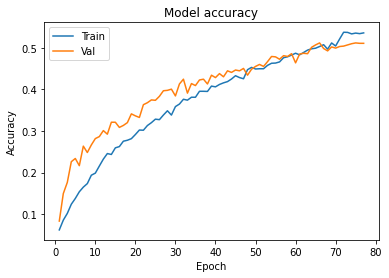

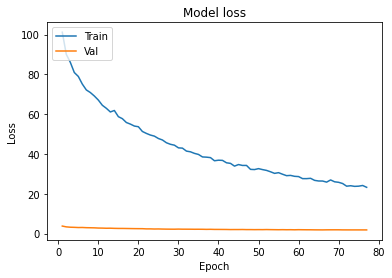

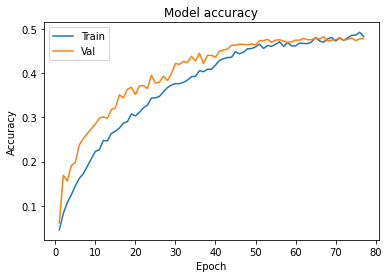

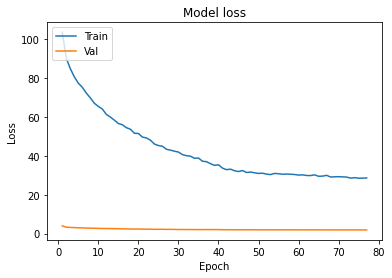

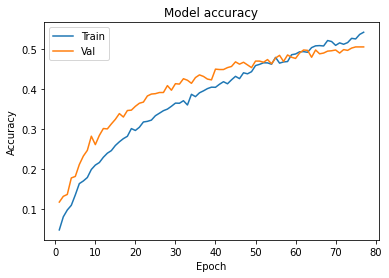

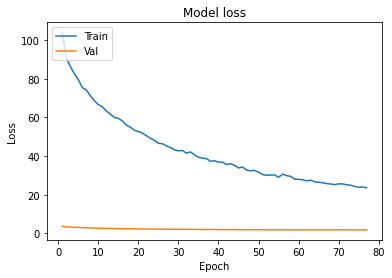

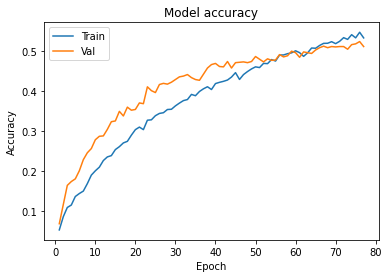

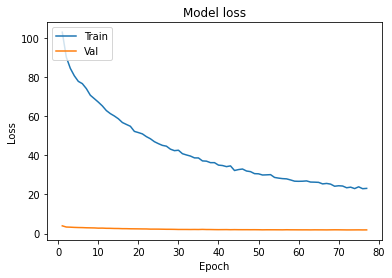

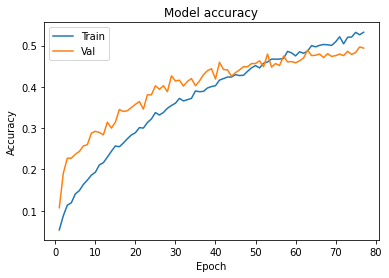

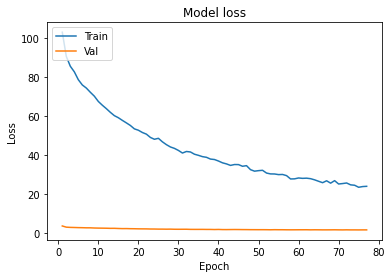

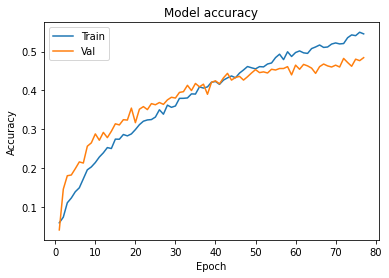

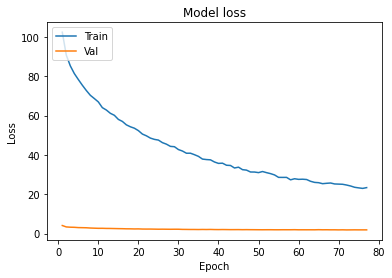

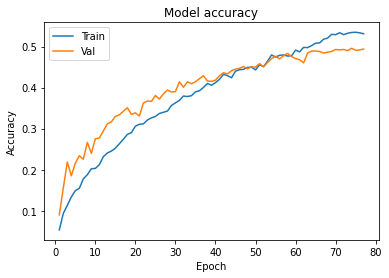

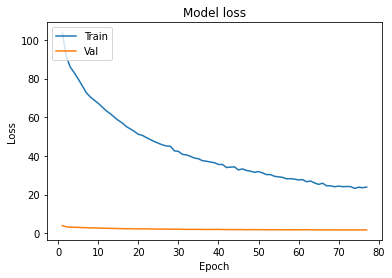

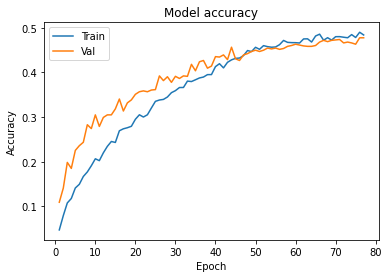

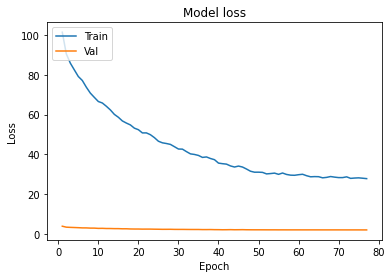

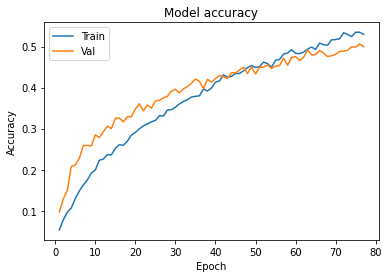

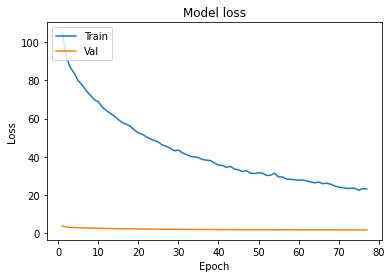

In [15]:
for record in history:
    plot_learningCurve(record, 77)

Take majority voting of the predictions of all the models 

In [16]:
def predict_labels(models, test_X):
    
    labels = []
    for m in models:
        predicts = np.argmax(m.predict(test_X), axis=1)
        labels.append(predicts)
    
    # Ensemble with voting
    labels = np.array(labels)
    labels = np.transpose(labels)
    labels = scipy.stats.mode(labels, axis=1)[0]
    labels = np.squeeze(labels)
    
    return labels

Import the test data

In [17]:
test = pd.read_csv('test.csv', header=None)

test_X = test.drop(columns=[0])
test_X = scaler.transform(test_X)

Reshape the test data to feed to Conv2D()

In [18]:
test_X = test_X.reshape(-1, 16, 60, 1)

Prediction on test data

In [19]:
labels = predict_labels(models, test_X)

<i>labels</i> are encoded and are in the range 0-48. <i>labels + 1</i> makes the range 1-49. <br /><br />
<i>Ids</i> start with 0, so <i>Id = test[0] - 1</i>, where <i>test[0]</i> is the <i>Id</i> column of the test data.

In [20]:
y_pred = pd.DataFrame({'Id': test[0]-1, 'Category':labels+1})

In [21]:
y_pred = y_pred.set_index('Id')

Store the predictions in a csv file

In [22]:
y_pred.to_csv('pred23.csv')